<h1> Shearographic evaluation and filtering </h1>

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft
import scipy.signal
import scipy.ndimage
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from math import sqrt

Set FFT Mask

In [46]:
fft_mask = np.zeros((1200, 1920), np.float64)
fft_mask[150:350, :] = 1.0

load sheared images

In [47]:
unloaded = plt.imread('im0.png')
loaded = plt.imread('im2.png')

Plot one as example

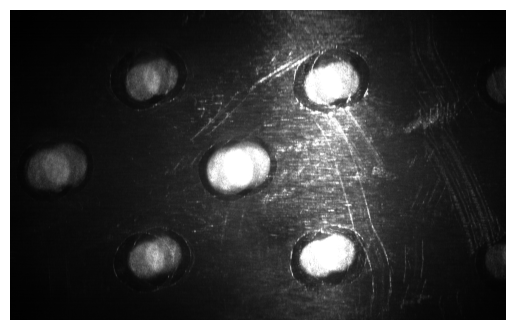

In [48]:
plt.imshow(unloaded, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

Multiply both images by FFT mask in frequency domain

In [49]:
masked_unloaded_fft = (fft_mask * scipy.fft.fftshift(scipy.fft.fft2(unloaded), axes=(-2, -1)))
masked_loaded_fft = (fft_mask * scipy.fft.fftshift(scipy.fft.fft2(loaded), axes=(-2, -1)))

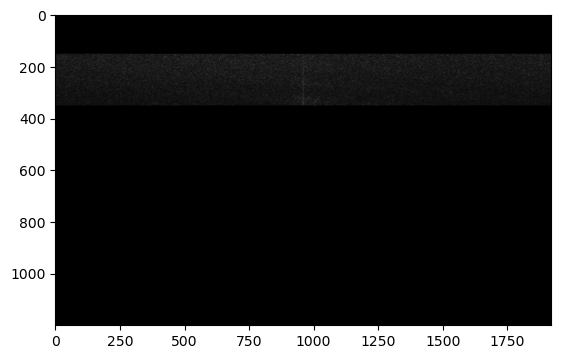

In [50]:
plt.imshow(np.abs(masked_unloaded_fft), cmap=plt.cm.gray)
plt.show()

Plot images after masking.

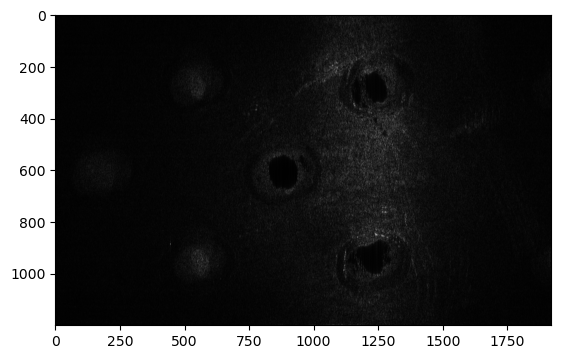

In [51]:
re_loaded = scipy.fft.ifft2(masked_loaded_fft)
plt.imshow(np.abs(re_loaded), cmap=plt.cm.gray)
plt.show()

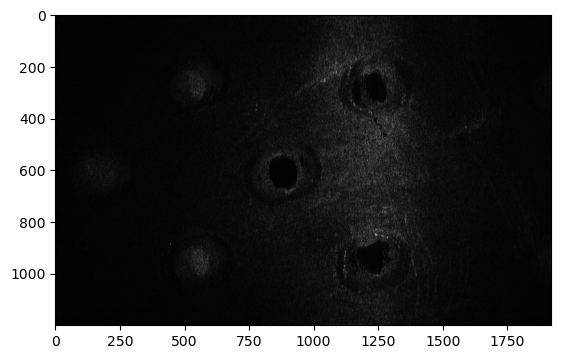

In [52]:
re_unloaded = scipy.fft.ifft2(masked_unloaded_fft)
plt.imshow(np.abs(re_unloaded), cmap=plt.cm.gray)
plt.show()

Figure 6.1

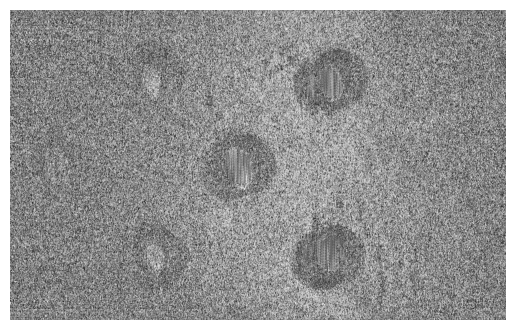

In [53]:
phase_image = np.angle(re_loaded) - np.angle(re_unloaded)

phase_image[phase_image < -np.pi] = phase_image[phase_image < -np.pi] + 2 * np.pi
phase_image[phase_image > np.pi] = phase_image[phase_image > np.pi] - 2 * np.pi

plt.imshow(phase_image, cmap=plt.cm.gray)
plt.axis('off')
plt.savefig('noisy_shearogram', bbox_inches = 'tight')
plt.show()

Figure 6.2

Filter sin and cos by kernels of different size.

In [54]:
def sin_cos_mean(phase_image):
    # define used kernels
    kernels = np.array([[3, 6],
                        [5, 5],
                        [7, 7],
                        [9, 9]])
    
    # filter sin and cos
    sin_filtered = np.sin(phase_image)
    cos_filtered = np.cos(phase_image)

    # Create mean filter kernel with above defined size [kernelX, kernelY]
    filter_kernel = np.ones(kernels[0, :], dtype=phase_image.dtype) / np.prod(kernels[0, :])

    for k in np.arange(0, kernels.shape[0]):
        if k > 0:
            if np.all(kernels[k - 1, :] != kernels[k, :]):
                # New kernel creation
                filter_kernel = np.ones(kernels[k, :], dtype=phase_image.dtype) / \
                                np.prod(kernels[k, :])

        sin_filtered = scipy.ndimage.convolve(sin_filtered, filter_kernel)
        cos_filtered = scipy.ndimage.convolve(cos_filtered, filter_kernel)

    # compute arctan
    filtered_phase_image = np.arctan2(sin_filtered, cos_filtered)

    return filtered_phase_image

673 ms ± 8.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


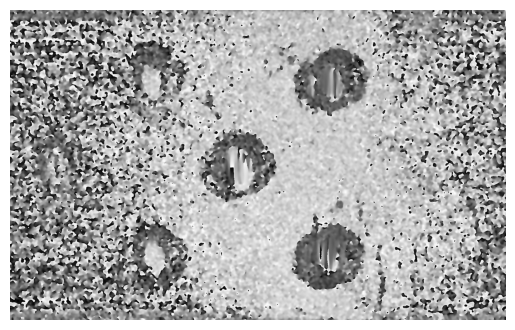

In [60]:
sin_cos_denoised = sin_cos_mean(phase_image)
%timeit sin_cos_mean(phase_image)
plt.imshow(sin_cos_denoised, cmap=plt.cm.gray)
plt.axis('off')
plt.savefig('mean_denoised', bbox_inches = 'tight')
plt.show()

Use Median filter on sin and cos

In [61]:
def sin_cos_median(phase_image):
    
    # filter sin and cos
    sin_filtered = np.sin(phase_image)
    cos_filtered = np.cos(phase_image)

    # apply median filter 
    sin_filtered = scipy.signal.medfilt2d(sin_filtered)
    cos_filtered = scipy.signal.medfilt2d(cos_filtered)
    
    # compute arctan
    filtered_phase_image = np.arctan2(sin_filtered, cos_filtered)

    return filtered_phase_image

456 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


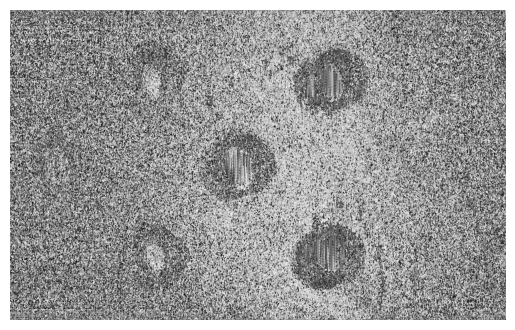

In [62]:
sin_cos_med_denoised = sin_cos_median(phase_image)
%timeit sin_cos_median(phase_image)
plt.imshow(sin_cos_med_denoised, cmap=plt.cm.gray)
plt.axis('off')
plt.savefig('median_denoised', bbox_inches = 'tight')
plt.show()

Figure 6.3

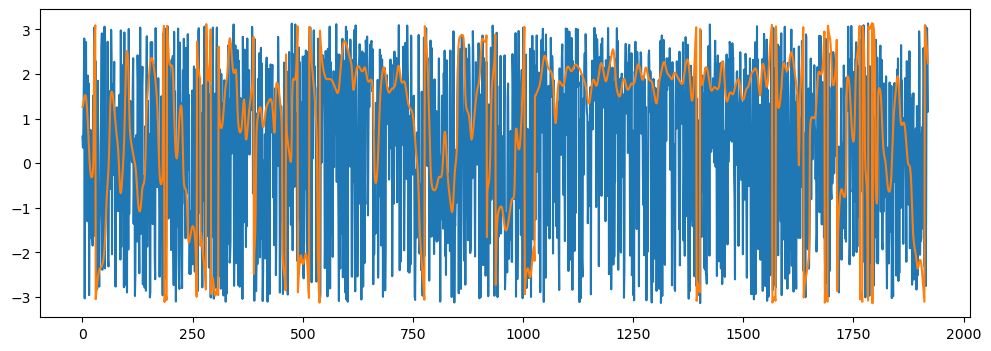

In [63]:
fig = plt.figure(figsize=(12, 4))

plt.plot(phase_image[600, :])
plt.plot(sin_cos_denoised[600, :])
plt.savefig('sin_cos_mean')
plt.show()

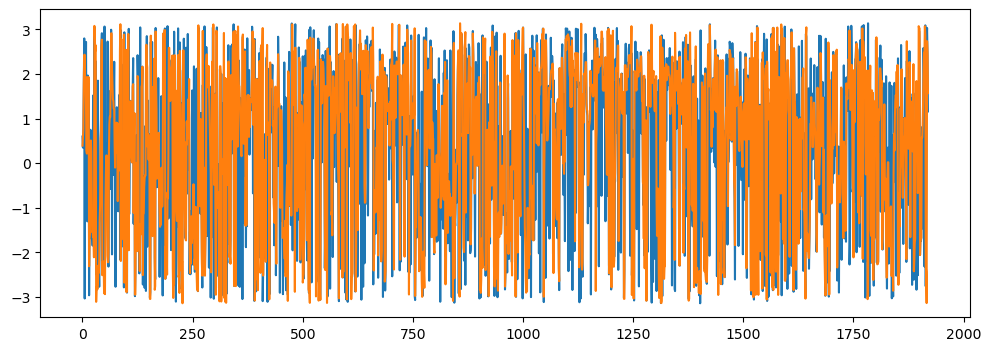

In [64]:
fig = plt.figure(figsize=(12, 4))

plt.plot(phase_image[600, :])
plt.plot(sin_cos_med_denoised[600, :])
plt.savefig('sin_cos_median')
plt.show()